In [1]:
from fenics import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
from egfcore import *
from utils import *

set_log_level(30)
%matplotlib widget

In [2]:
class Simulator:
    
    def __init__(self, meshDensity):
        self.mesh = IntervalMesh(meshDensity,0,1) # (meshDensity = N_sensors) =  # of positions at which the problem is discretized on a unit interval
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh.mat", mesh_dict)
        self.V = FunctionSpace(self.mesh, 'P', 2)
        
        # Define the function space and store the meshweights for computation.
        V = FunctionSpace(self.mesh,'P',1)
        u = TestFunction(V)
        temp = assemble(u*dx)
        self.meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
        
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh2D.mat", mesh_dict)
        
        # Create variational form for the problem
        self.bc = self.boundaryConditions()
        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        self.f = Function(V)
        self.param = Constant(0)
        self.d2v = dof_to_vertex_map(V)
        self.a = (-dot(grad(u), grad(v)) + self.param*self.param*dot(u,v))* dx
        self.L = self.f*v*dx
        self.u = Function(self.V)
        
    def boundaryConditions(self):
        """
        Define homogeneous Dirichlet Boundary conditions for the problem.
        """
        def boundary(x, on_boundary):
            return on_boundary
        
        u_D = Constant(0)
        bc = DirichletBC(self.V, u_D, boundary)
        
        return bc
    
    def solve(self, forcing, noise_level = None, param=None):
        """
        Given a (N_sensors x 1) forcing vector, solve the a 1D Helmholtz problem on a unit interval.
        """
        
        self.f.vector()[:] = forcing[self.d2v] # Instantiate the source term in the variational form by interpolating the sampled sourcing term.
        if param is not None:
            self.param.assign(param) # Define the parameter for the problem
        solve(self.a == self.L, self.u, self.bc) # Solve the variation form

        # Sample the solution at the nodes of the mesh.
        solution = self.u.compute_vertex_values(self.mesh)
        
        # As specified, add IID Gaussian white noise.
        if noise_level is not None:
            noise =  noise_level*np.random.normal(0,np.abs(solution.mean()),solution.shape)
            solution += noise
        
        return solution

In [3]:
%%time
add_noise = False
noise_level = 0.1
verbose = False

paramSet = np.array([[4.8], [4.9], [5.1], [5.0]])
# paramSet = np.array([[3.0], [4.0], [6.0], [5.0]])
meshDensity = 2000
sigma = 0.005
rank = 100
nSamples = rank

Sim = Simulator(meshDensity)
forcing = sampleforcing(sigma, nSamples)

models = []
for i, params in enumerate(paramSet):

    np.random.seed(42)

    print(f"Helmholtz (Theta = $ {params[0]}) | Method: Randomized SVD | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")


    meshweights = Sim.meshweights

    # Generate an forcing and output ensemble by simulating Poisson problem with FENICS.
    solution = np.zeros(forcing.shape)
    for i in range(solution.shape[1]):
        if verbose:
            print("i = %d / %d"%(i+1, solution.shape[1]))
        if add_noise:
            solution[:,i] = Sim.solve(forcing[:,i], noise_level, params[0])
        else:
            solution[:,i] = Sim.solve(forcing[:,i], None, params[0])

    if add_noise:
        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, noise_level, None, None, Sim, verbose = verbose)
    else:
        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, None, None, None, Sim, verbose = verbose)
        
    models.append(model)

Helmholtz (Theta = $ 4.8) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
Helmholtz (Theta = $ 4.9) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
Helmholtz (Theta = $ 5.1) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
Helmholtz (Theta = $ 5.0) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False
CPU times: user 7.12 s, sys: 1.72 s, total: 8.84 s
Wall time: 38.9 s


Text(0.5, 1.0, ' Helmholtz | Randomized SVD | (Theta = 5.1) ')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
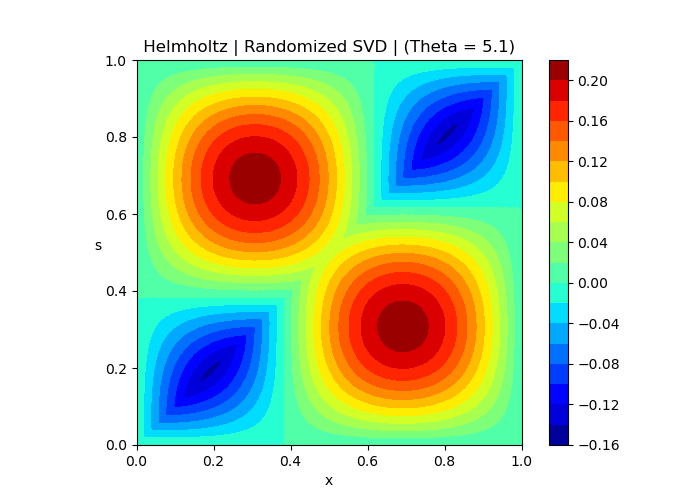

In [4]:
idx = 2
plotGreen1D(models[idx])
plt.title(f" Helmholtz | Randomized SVD | (Theta = {models[idx].params[0]}) ")

In [5]:
%%time

print(f"Parameter set: {paramSet}")
interpSet = [models[0], models[1], models[2]]
# interpSet = [models[0], models[2]]


targetParam = paramSet[-1]
targetModel = models[-1]
inputdata = models[-1].forcing #compute_forcing(pSim.mesh, numSteps)
simulator = Sim

interpModel, U_set, coeffs_set = model_interp(interpSet, simulator, inputdata, targetParam, verbose = False)

Parameter set: [[4.8]
 [4.9]
 [5.1]
 [5. ]]
CPU times: user 625 ms, sys: 214 ms, total: 839 ms
Wall time: 242 ms


Text(0.5, 1.0, 'Coefficients (S)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
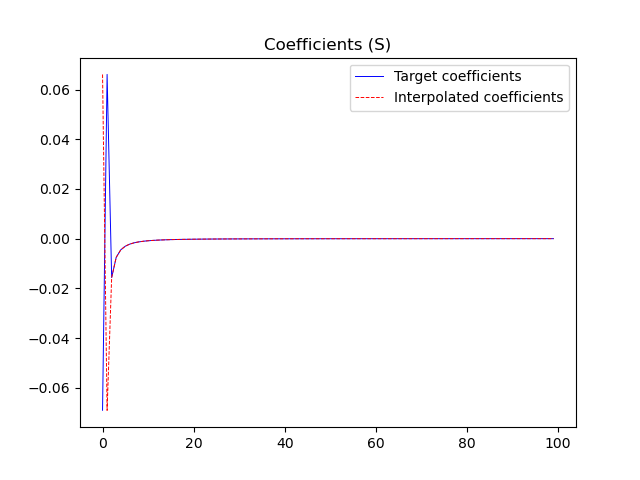

In [6]:
plt.figure()
plt.plot(targetModel.dcoeffs,'b-', linewidth = 0.7, alpha = 1)
plt.plot(interpModel.dcoeffs,'r--', linewidth = 0.7, alpha = 1)
plt.legend(['Target coefficients','Interpolated coefficients'])
plt.title('Coefficients (S)')

Text(0.5, 1.0, 'Interpolated Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
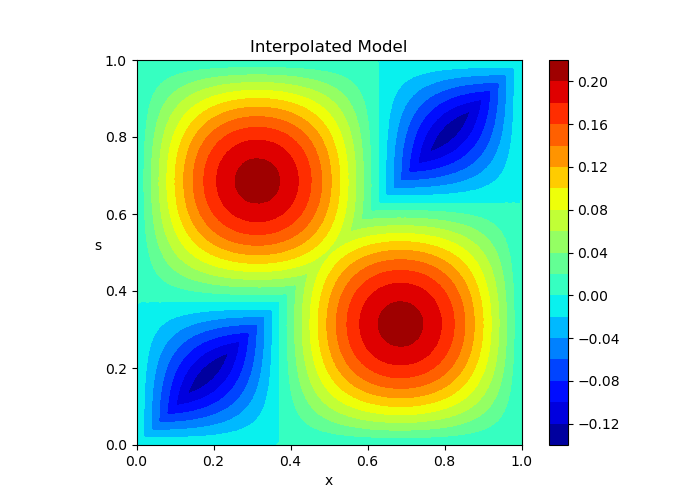

In [7]:
plotGreen1D(interpModel)
plt.title('Interpolated Model')

Text(0.5, 1.0, 'Target Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
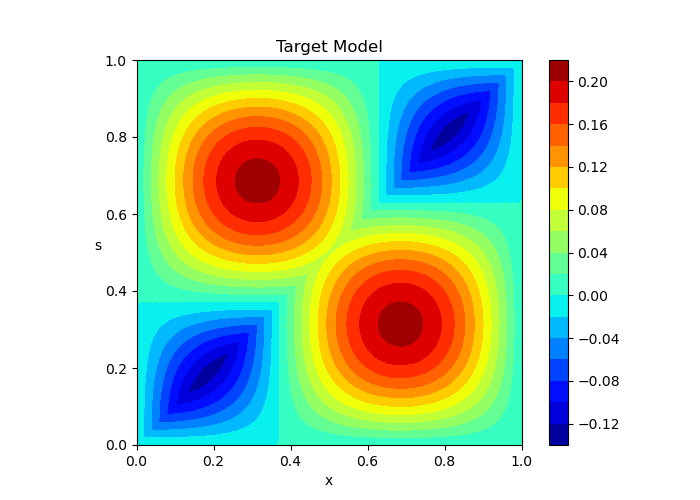

In [8]:
plotGreen1D(targetModel)
plt.title('Target Model')

In [9]:
def comparepaper(model1, model2):
    modes = [0,1]
    x = np.linspace(0,1,model.signal.shape[0])
    fig = plt.figure(figsize = (13,4))
    
    plt.tight_layout()
    plt.subplots_adjust(left = 0.05, wspace=0.3, hspace=0.3)
    
    plt.subplot(121)
    plt.plot(x,model1.modeset[:,modes[0]])
    plt.plot(x,model1.modeset[:,modes[1]])
    plt.xlim([0,1])
    plt.xlabel('x')
    plt.title(f"Modes for model at $\\theta = {model1.params[0]}$")
    # plt.title('A',loc ='left', weight = 'bold', size = 12)
    plt.legend([f"Mode {modes[0]+1}", f"Mode {modes[1]+1}"])

    plt.subplot(122)
    plt.plot(x,model2.modeset[:,modes[0]])
    plt.plot(x,model2.modeset[:,modes[1]])
    plt.xlim([0,1])
    plt.xlabel('x')
    plt.title(f"Modes for model at $\\theta = {model2.params[0]}$")
    # plt.title('B',loc ='left', weight = 'bold', size = 12)
    plt.legend([f"Mode {modes[0]+1}", f"Mode {modes[1]+1}"])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
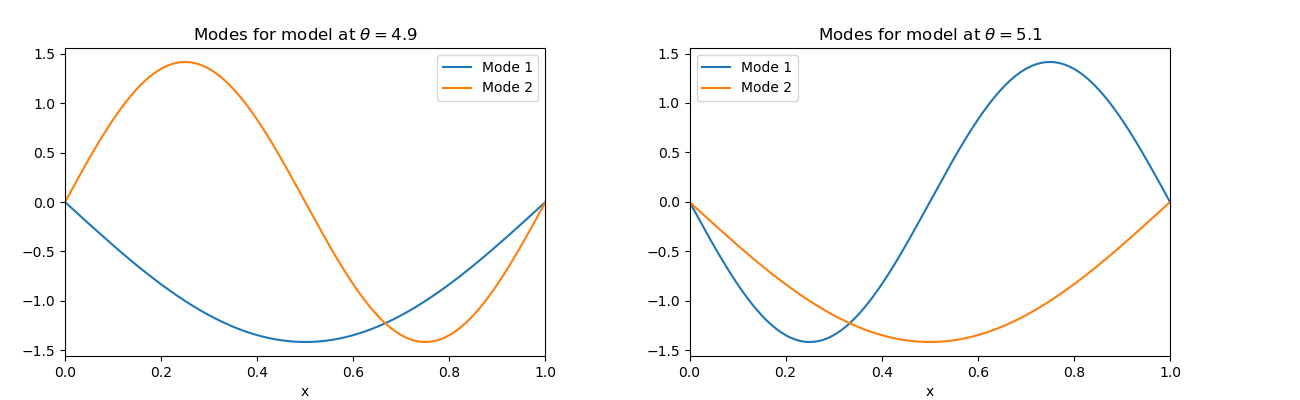

In [10]:
comparepaper(models[1],models[2])